In [10]:
!pip install asyncpraw
!pip install config

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 4.5 MB/s eta 0:00:00


In [19]:
# Packages

import re
import praw
import config
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## Load Data

In [21]:
# Configure and authenticate with Reddit API using your credentials
api_reddit = praw.Reddit(client_id="replace with your data", client_secret="replace with your data", password="replace with your data", user_agent="replace with your data", username="replace with your data")

# Define subreddits from which to scrape posts
assuntos = ['datascience', 'machinelearning', 'physics', 'astrology', 'conspiracy']

# Initialize list to hold text data
data = []

# Initialize list to hold label indices corresponding to subreddits
labels = []

# Lambda function to remove non-alphanumeric characters and count remaining characters in post text
char_count = lambda post: len(re.sub('\W|\d', '', post.selftext))

# Lambda function to check if post text has at least 100 characters
mask = lambda post: char_count(post) >= 100

# Loop through each subreddit, fetch and filter posts, and append them to the data and labels lists
for i, assunto in enumerate(assuntos):
    # Access the subreddit
    subreddit_data = api_reddit.subreddit(assunto).new(limit=1000)
    # Filter posts using the mask and extract their text
    posts = [post.selftext for post in filter(mask, subreddit_data)]
    # Extend the data list with these posts
    data.extend(posts)
    # Append corresponding index to labels list for each post
    labels.extend([i] * len(posts))
    # Output the number of posts fetched and a snippet of one post
    print(f"Número of posts about r/{assunto}: {len(posts)}", f"\nSample of one post: {posts[0][:600]}...\n", "_" * 80 + '\n')


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Número de posts do assunto r/datascience: 461 
Um dos posts extraídos: One of the trending repos on GitHub for a week, genesis-world is a python package which can generate realistic 4D physics simulations (with no irregularities in any mechanism) given just a prompt. The early samples looks great and the package is open-sourced (except the GenAI part). Check more details here : https://youtu.be/hYjuwnRRhBk?si=i63XDcAlxXu-ZmTR...
 ________________________________________________________________________________



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Número de posts do assunto r/machinelearning: 820 
Um dos posts extraídos: hi guys im a phd student doing reinforcement learning and transformer for real world application. I want tp get a powerful laptop that lasts me for the entirety of my phd.

im confused between two options:

\- MacBook Pro m4 max 64 gb unified memory vs

\- Razer Blade 16 (2024) - 16 inch Gaming Laptop - NVIDIA GeForce RTX 4080 - Intel Core i9-14900HX (32GB DDR5, 1TB SSD)

could anyone help me decide? also if you have any better suggestions please lmk.

I will be using the hpc for most training, I need for inference and designing to test before running on hpc...
 ________________________________________________________________________________



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Número de posts do assunto r/physics: 264 
Um dos posts extraídos: # Book Recommendation:

Hi! I Have always wanted to get into physics, I Have always been fascinated with science and math basically STEM and I really the idea of knowing how the world around you works. Anyways I Need a Book, I Wanted a book that had a lot of chapters and going over all of physics, and mainly I have two options:

**Physics: Principles with Applications by Douglas C. Giancoli**

**University Physics (With Modern Physics) by High D. Young**

I Don't really mind the calculus in university physics, nor I really need it.

So kind of, Both of these are great options, I don't really m...
 ________________________________________________________________________________



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Número de posts do assunto r/astrology: 531 
Um dos posts extraídos: I just finished listening to The Astrology Podcast’s year ahead episode for 2025 and really enjoyed hearing Chris Brennan talk about the way eclipses will be lighting up two houses in each sign and the themes that will come from them. 

I would love to dive jnto the subject a little more now and see not only what eclipses mean in astrology in general, but how they manifest in people’s lives and what the upcoming eclipses over the next few years are predicted to be. Would appreciate any links or free/low-cost sources others may know of! ...
 ________________________________________________________________________________



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Número de posts do assunto r/conspiracy: 532 
Um dos posts extraídos: I thought countries like Argentina and Venezuela had out of control inflation? What cause the inflation in Argentina and Venezuela.

I hear today there still high inflation in Argentina and Venezuela and it is not coming down but getting worse.



...
 ________________________________________________________________________________



## Split data

In [22]:
# Define the proportion of data to set aside for testing
TEST_SIZE = .2
# Set a random seed for reproducibility
RANDOM_STATE = 0

# Split the data and labels into training and testing sets
X_treino, X_teste, y_treino, y_teste = train_test_split(data, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
# Print the number of samples in the test set
print(f"{len(y_teste)} test samples.")


522 amostras de teste.


# Preprocessing Pipeline

In [23]:
# Define a pattern to identify unwanted characters in the text
pattern = r'\W|\d|http.*\s+|www.*\s+'

# Define a preprocessor that removes unwanted characters from text
preprocessor = lambda text: re.sub(pattern, ' ', text)

# Configure the TF-IDF vectorizer with the custom preprocessor
vectorizer = TfidfVectorizer(preprocessor=preprocessor, stop_words='english', min_df=1)

# Set up the Truncated SVD to reduce the dimensionality of the feature set
decomposition = TruncatedSVD(n_components=1000, n_iter=30)

# Combine the vectorizer and SVD into a preprocessing pipeline
pipeline = [('tfidf', vectorizer), ('svd', decomposition)]


# Model Creation

In [24]:
# Initialize a K-Nearest Neighbors model with 4 neighbors
modelo_1 = KNeighborsClassifier(n_neighbors=4)

# Initialize a Random Forest model with a random state for reproducibility
modelo_2 = RandomForestClassifier(random_state=RANDOM_STATE)

# Initialize a Logistic Regression model with cross-validation
modelo_3 = LogisticRegressionCV(cv=3, random_state=RANDOM_STATE)

# Combine all models into a list for later processing
all_models = [("KNN", modelo_1), ("RandomForest", modelo_2), ("LogReg", modelo_3)]



# Train and Evaluate Models

In [25]:
# Initialize an empty list to store results
resultados = []

# Loop through each model, fit it on the training data, and evaluate it on the test data
for name, modelo in all_models:
    # Create a pipeline combining the preprocessing pipeline with the current model
    pipe = Pipeline(pipeline + [(name, modelo)])
    # Train the model
    pipe.fit(X_treino, y_treino)
    # Predict the labels of the test set
    y_pred = pipe.predict(X_teste)
    # Generate a classification report
    report = classification_report(y_teste, y_pred)
    # Print the classification report
    print(f"{name} report\n", report)
    # Store the model and its evaluation results in the list
    resultados.append([modelo, {'model': name, 'predictions': y_pred, 'report': report}])


Relatório de Classificação para KNN
               precision    recall  f1-score   support

           0       0.57      0.60      0.59        86
           1       0.63      0.86      0.73       168
           2       0.91      0.57      0.70        51
           3       0.84      0.80      0.82       106
           4       0.87      0.55      0.67       111

    accuracy                           0.71       522
   macro avg       0.76      0.68      0.70       522
weighted avg       0.74      0.71      0.71       522

Relatório de Classificação para RandomForest
               precision    recall  f1-score   support

           0       0.75      0.31      0.44        86
           1       0.64      0.94      0.76       168
           2       1.00      0.47      0.64        51
           3       0.90      0.88      0.89       106
           4       0.78      0.78      0.78       111

    accuracy                           0.75       522
   macro avg       0.81      0.68      0.70     

# Visualize Results

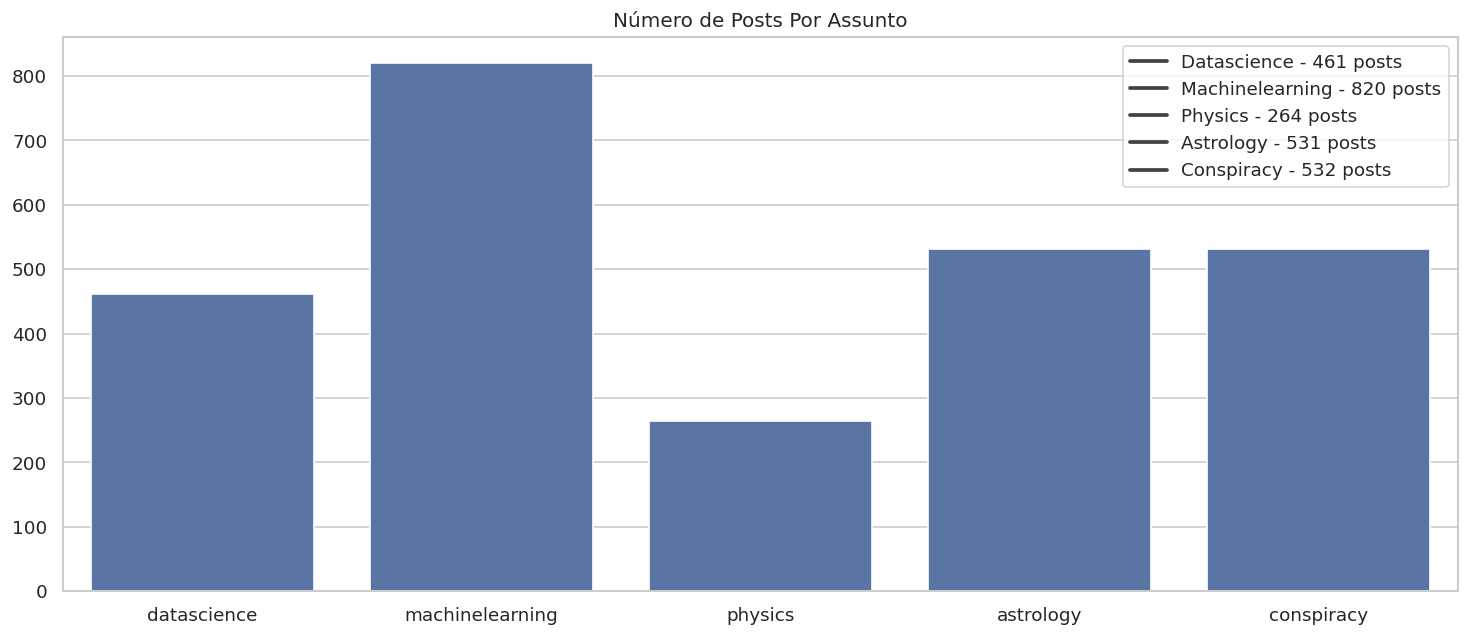

In [26]:
# Calculate the count of posts per subreddit
_, counts = np.unique(labels, return_counts=True)

# Set the seaborn theme for visualizations
sns.set_theme(style="whitegrid")

# Create a bar plot to visualize the number of posts per subreddit
plt.figure(figsize=(15, 6), dpi=120)
plt.title("Number of post per subjects")
sns.barplot(x=assuntos, y=counts)

# Add a legend to the plot
plt.legend([' '.join([f.title(), f"- {c} posts"]) for f, c in zip(assuntos, counts)])
plt.show()


# Plot Confusion Matrix

In [29]:
# Function to display a confusion matrix for a given result
def plot_confusion(result):
    # Print the classification report
    print("Classification report\n", result['report'])

    # Extract predicted labels
    y_pred = result['predictions']

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_teste, y_pred)

    # Normalize the confusion matrix
    _, test_counts = np.unique(y_teste, return_counts=True)
    conf_matrix_percent = conf_matrix / test_counts.transpose() * 100

    # Plot the normalized confusion matrix
    plt.figure(figsize=(9, 8), dpi=120)
    plt.title(result['modelo'].upper() + " Resultados")
    plt.xlabel("Valor Real")
    plt.ylabel("Previsão do Modelo")
    ticklabels = [f"r/{sub}" for sub in assuntos]
    sns.heatmap(data=conf_matrix_percent, xticklabels=ticklabels, yticklabels=ticklabels, annot=True, fmt='.2f')
    plt.show()

# Execute the function for each model's results
for result in resultados:
    plot_confusion(result[1])


Classification report
               precision    recall  f1-score   support

           0       0.57      0.60      0.59        86
           1       0.63      0.86      0.73       168
           2       0.91      0.57      0.70        51
           3       0.84      0.80      0.82       106
           4       0.87      0.55      0.67       111

    accuracy                           0.71       522
   macro avg       0.76      0.68      0.70       522
weighted avg       0.74      0.71      0.71       522



KeyError: 'predictions'